In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
extent = Ross_Extent['Extent']
W_S=12
X,y = fp.df_to_X_y(extent, W_S)
X.shape, y.shape

((526, 12, 1), (526,))

In [7]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 41s 528ms/step - loss: 0.3174 - root_mean_squared_error: 0.5634 - val_loss: 0.1645 - val_root_mean_squared_error: 0.4056
Epoch 2/50
53/53 [==============================] - 26s 504ms/step - loss: 0.0990 - root_mean_squared_error: 0.3146 - val_loss: 0.0850 - val_root_mean_squared_error: 0.2915
Epoch 3/50
53/53 [==============================] - 25s 489ms/step - loss: 0.0705 - root_mean_squared_error: 0.2654 - val_loss: 0.0786 - val_root_mean_squared_error: 0.2803
Epoch 4/50
53/53 [==============================] - 25s 485ms/step - loss: 0.0596 - root_mean_squared_error: 0.2442 - val_loss: 0.0690 - val_root_mean_squared_error: 0.2628
Epoch 5/50
53/53 [==============================] - 25s 485ms/step - loss: 0.0509 - root_mean_squared_error: 0.2255 - val_loss: 0.0588 - val_root_mean_squared_error: 0.2425
Epoch 6/50
53/53 [==============================] - 25s 488ms/step - loss: 0.0401 - root_mean_squared_error: 0.2003 - val_loss: 0.0461 

Epoch 33/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 34/50
53/53 [==============================] - 3s 58ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 35/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 36/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773
Epoch 37/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 38/50
53/53 [==============================] - 4s 68ms/step - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0062 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

10.788616283734639 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

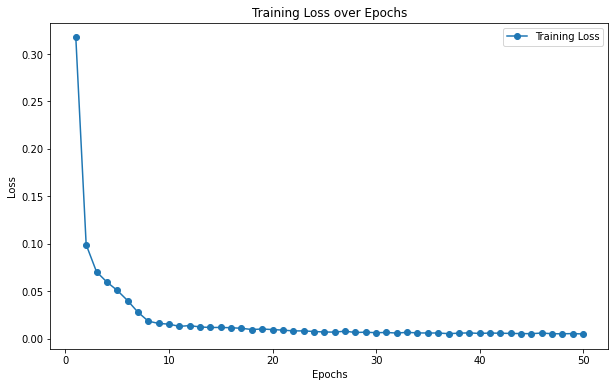

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

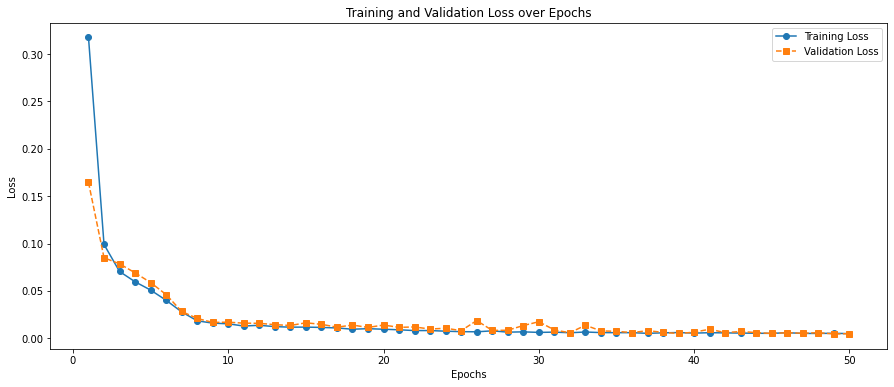

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model/')

In [9]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 32ms/step


In [10]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06623110880029402
MAE : 0.053452966420623756


In [11]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [12]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.626622e+06,2649273.174
1,3.278184e+06,3168444.759
2,3.591399e+06,3656196.531
3,3.788098e+06,3794128.369
4,3.870006e+06,3885746.442
5,3.842296e+06,3909211.179
6,3.479428e+06,3499167.351
7,2.546392e+06,2715890.297
8,8.921569e+05,1053272.694
9,6.365964e+05,368862.123


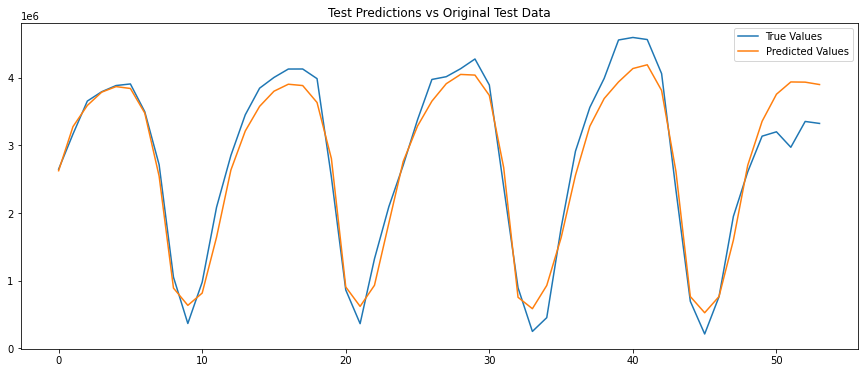

In [13]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [14]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [17]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

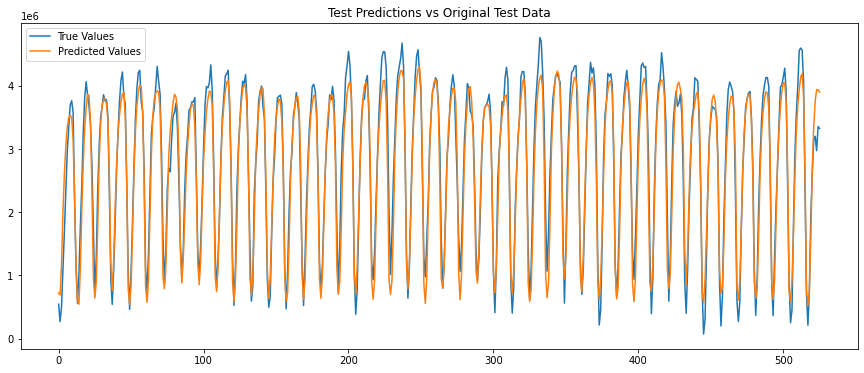

In [18]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()